In [1]:
import scipy.interpolate as interp
import os
import openFOAM as foam
import sys
sys.path.append("..")
import numpy as np
import csv as csv

from tempfile import mkstemp
from shutil import move
from shutil import copy
from os import remove, close
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt

In [2]:
def RANS(Re, TurbModel, time_end, nx_RANS, ny_RANS):
    home = os.path.realpath('MinorCSE') + '/'
    dir_RANS  = home + ('Re%i_%s' % (Re,TurbModel))
    
    meshRANSlist  = foam.getRANSVector(dir_RANS, time_end, 'cellCentres')
    meshRANS      = foam.getRANSPlane(meshRANSlist,'2D', nx_RANS, ny_RANS, 'vector')
    #velocity
    U_RANSlist    = foam.getRANSVector(dir_RANS, time_end, 'U')
    U_RANS        = foam.getRANSPlane(U_RANSlist,'2D', nx_RANS, ny_RANS, 'vector')
    #velocity gradient
    gradU_RANSlist  = foam.getRANSTensor(dir_RANS, time_end, 'grad(U)')
    gradU_RANS      = foam.getRANSPlane(gradU_RANSlist,'2D', nx_RANS, ny_RANS, 'tensor')
    #pressure
    p_RANSlist    = foam.getRANSScalar(dir_RANS, time_end, 'p')
    p_RANS        = foam.getRANSPlane(p_RANSlist,'2D', nx_RANS, ny_RANS, 'scalar')
    #pressure gradient
    gradp_RANSlist    = foam.getRANSVector(dir_RANS, time_end, 'grad(p)')
    gradp_RANS        = foam.getRANSPlane(gradp_RANSlist,'2D', nx_RANS, ny_RANS, 'vector')
    #Reynolds stress tensor
    tau_RANSlist  = foam.getRANSSymmTensor(dir_RANS, time_end, 'R')
    tau_RANS      = foam.getRANSPlane(tau_RANSlist,'2D', nx_RANS, ny_RANS, 'tensor')
    #k
    k_RANSlist    = foam.getRANSScalar(dir_RANS, time_end, 'k')
    k_RANS        = foam.getRANSPlane(k_RANSlist,'2D', nx_RANS, ny_RANS, 'scalar')
    #k gradient
    gradk_RANSlist    = foam.getRANSVector(dir_RANS, time_end, 'grad(k)')
    gradk_RANS        = foam.getRANSPlane(gradk_RANSlist,'2D', nx_RANS, ny_RANS, 'vector')
    #distance to wall
    yWall_RANSlist = foam.getRANSScalar(dir_RANS, time_end, 'yWall')
    yWall_RANS        = foam.getRANSPlane(yWall_RANSlist,'2D', nx_RANS, ny_RANS, 'scalar')
    #omega
    omega_RANSlist  = foam.getRANSScalar(dir_RANS, time_end, 'omega')
    omega_RANS      = foam.getRANSPlane(omega_RANSlist, '2D', nx_RANS, ny_RANS, 'scalar')
    #S R tensor
    S_RANS, Omega_RANS  = foam.getSRTensors(gradU_RANS)
    
    return meshRANS, U_RANS, gradU_RANS, p_RANS, gradp_RANS, tau_RANS, k_RANS, gradk_RANS, yWall_RANS, omega_RANS, S_RANS, Omega_RANS
    


In [3]:
def q1(S_RANS, Omega_RANS): 
    a = np.shape(S_RANS)
    q1 = np.zeros((a[2],a[3]))
    for i1 in range(a[2]):
        for i2 in range(a[3]):               
            raw = 0.5*(np.abs(np.trace(np.dot(S_RANS[:,:,i1,i2],S_RANS[:,:,i1,i2]))) - np.abs(np.trace(np.dot(Omega_RANS[:,:,i1,i2],-1*(Omega_RANS[:,:,i1,i2])))))
            norm = np.trace(np.dot(S_RANS[:,:,i1,i2],S_RANS[:,:,i1,i2]))
            q1[i1,i2] = raw/(np.abs(raw) + np.abs(norm))
    return q1

def q2(k_RANS, U_RANS):
    a = np.shape(k_RANS)
    b= np.shape(U_RANS)
    #print( "shape urans=", b)
    q2 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):               
            raw = k_RANS[0,i1,i2]
            norm = 0.5*(np.inner(U_RANS[:, i1, i2], U_RANS[:, i1, i2])) # inner is equivalent to sum UiUi
            q2[i1,i2] = raw/(np.abs(raw) + np.abs(norm))
    return q2

    
def q3(k_RANS, yWall_RANS, nu=1.4285714285714286e-03):
    a = np.shape(k_RANS)
    q3 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):               
            q3[i1,i2] = np.minimum((np.sqrt(k_RANS[:,i1,i2][0])*yWall_RANS[:, i1, i2])/(50*nu), 2)
    return q3
    

def q4(U, gradP):
    a = np.shape(gradP)
    q4 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):
            raw  = np.einsum('k,k', U[:,i1,i2], gradP[:,i1,i2])
            norm = np.einsum('j,j,i,i', gradP[:,i1,i2], gradP[:,i1,i2], U[:, i1, i2],U[:, i1, i2])
            
            q4[i1,i2] = raw / (np.fabs(norm) + np.fabs(raw));
    return q4


def q5(k_RANS, S_RANS, omega_RANS, Cmu=0.09):
    a = np.shape(k_RANS)
    q5 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):    
            epsilon = Cmu * k_RANS[:, i1, i2] * omega_RANS[:, i1, i2]
            raw = k_RANS[:, i1, i2] / epsilon
            norm = 1 / np.sqrt(np.trace(np.dot(S_RANS[:, :, i1, i2],S_RANS[:, :, i1, i2])))
            q5[i1,i2] = raw/(np.fabs(raw) + np.fabs(norm))
    return q5


def q6(gradP, gradU, p_RANS, U_RANS):
    a = np.shape(gradP)
    q6 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):
            raw  = np.sqrt(np.einsum('i,i', gradP[:, i1, i2], gradP[:, i1, i2]))
            norm = np.einsum('k,kk', U_RANS[:, i1, i2], gradU[:, :, i1, i2])
           
            norm *= 0.5 * p_RANS[0, i1, i2]
            q6[i1,i2] = raw/(np.fabs(raw) + np.fabs(norm))
    return q6
    

def q7(U_RANS, gradU_RANS):
    a = np.shape(U_RANS)
    q7 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):    
            raw = np.fabs(np.einsum('i, j, ij', U_RANS[:, i1, i2], U_RANS[:, i1, i2], gradU_RANS[:, :, i1, i2]))
            norm = np.sqrt(np.einsum('l, l, i, ij, k, kj', U_RANS[:, i1, i2], U_RANS[:, i1, i2],U_RANS[:, i1, i2], gradU_RANS[:, :, i1, i2], U_RANS[:, i1, i2], gradU_RANS[:, :, i1, i2]))
            q7[i1,i2] = raw/(np.fabs(raw) + np.fabs(norm))
    return q7



def q8(U, gradK, Tau, S):
    a = np.shape(U)
    q8 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):
            raw  = np.einsum('i,i',U[:,i1,i2], gradK[:,i1,i2])
            norm = np.einsum('jk,jk', Tau[:,:, i1, i2], S[:,:, i1, i2])
            q8[i1,i2] = raw/(np.fabs(raw) + np.fabs(norm))              
    return q8
  

def q9(tau_RANS, k_RANS):
    a = np.shape(k_RANS)
    q9 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):    
            raw = np.sqrt(np.trace(np.dot(tau_RANS[:, :, i1, i2],np.transpose(tau_RANS[:, :, i1, i2]))))
            norm = k_RANS[:, i1, i2]
            q9[i1,i2] = raw/(np.fabs(raw) + np.fabs(norm))
    return q9

In [4]:
def features(Re, TurbModel='kOmega', time_end=30000, nx_RANS=140, ny_RANS=150):
    X = np.zeros((nx_RANS*len(Re) * ny_RANS, 9))
    
    for i in range(len(Re)):
        meshRANS, U_RANS, gradU_RANS, p_RANS, gradp_RANS, tau_RANS, k_RANS, gradk_RANS, yWall_RANS, omega_RANS, S_RANS, Omega_RANS = RANS(Re[i], TurbModel, time_end, nx_RANS, ny_RANS)
        feature = np.zeros((9, nx_RANS, ny_RANS))
        feature[0,:,:] = q1(S_RANS, Omega_RANS)
        feature[1,:,:] = q2(k_RANS, U_RANS)
        feature[2,:,:] = q3(k_RANS, yWall_RANS)
        feature[3,:,:] = q4(U_RANS, gradp_RANS)
        feature[4,:,:] = q5(k_RANS, S_RANS, omega_RANS)
        feature[5,:,:] = q6(gradp_RANS, gradU_RANS, p_RANS,U_RANS)
        feature[6,:,:] = q7(U_RANS, gradU_RANS)
        feature[7,:,:] = q8(U_RANS, gradk_RANS, tau_RANS, S_RANS)
        feature[8,:,:] = q9(tau_RANS, k_RANS)
        feature = np.reshape(feature.swapaxes(1,2), (nx_RANS*ny_RANS, 9), "F")
        feature = np.reshape(feature.swapaxes(1,0), (nx_RANS*ny_RANS, 9))
        X[i*nx_RANS*ny_RANS:(i+1)*nx_RANS*ny_RANS, :] = feature
    return X

In [5]:
def response(Re, nx_RANS=140, ny_RANS=150): 
    Y = np.zeros((nx_RANS*len(Re)*ny_RANS, 2))
    
    for i in range(len(Re)):
        home = os.path.realpath('MinorCSE') + '/'
        dataset = home + ('DATA_CASE_LES_BREUER') + '/' + ('Re_%i' % Re[i]) + '/' + ('Hill_Re_%i_Breuer.csv' % Re[i])
        meshRANS, U_RANS, gradU_RANS, p_RANS, gradp_RANS, tau_RANS, k_RANS, gradk_RANS, yWall_RANS, omega_RANS, S_RANS, Omega_RANS = RANS(Re[i], TurbModel='kOmega', time_end=30000, nx_RANS=140, ny_RANS=150)

        dataDNS = foam.loadData_avg(dataset)
        dataDNS_i = foam.interpDNSOnRANS(dataDNS, meshRANS)
        dataDNS_i['k'] = 0.5 * (dataDNS_i['uu'] + dataDNS_i['vv'] + dataDNS_i['ww'])

        l1 = np.shape(U_RANS)[1]
        l2 = np.shape(U_RANS)[2]

        ReStress_DNS = np.zeros([3,3,l1,l2])
        ReStress_DNS[0,0,:,:] = dataDNS_i['uu']
        ReStress_DNS[1,1,:,:] = dataDNS_i['vv']
        ReStress_DNS[2,2,:,:] = dataDNS_i['ww']
        ReStress_DNS[0,1,:,:] = dataDNS_i['uv']
        ReStress_DNS[1,0,:,:] = dataDNS_i['uv']

        aij_DNS = np.zeros([3,3,l1,l2])
        dataRANS_k = np.zeros([l1,l2])
        dataRANS_aij = np.zeros([3,3,l1,l2])

        for j in range(l1):
            for k in range(l2):
                aij_DNS[:,:,j,k] = ReStress_DNS[:,:,j,k]/(2.*dataDNS_i['k'][j,k]) - np.diag([1/3.,1/3.,1/3.])
                dataRANS_k[j,k] = 0.5 * np.trace(tau_RANS[:,:,j,k])
                dataRANS_aij[:,:,j,k] = tau_RANS[:,:,j,k]/(2.*dataRANS_k[j,k]) - np.diag([1/3.,1/3.,1/3.])

        eigVal_DNS = foam.calcEigenvalues(ReStress_DNS, dataDNS_i['k'])
        baryMap_DNS = foam.barycentricMap(eigVal_DNS)

        eigVal_RANS = foam.calcEigenvalues(tau_RANS, dataRANS_k)
        baryMap_RANS = foam.barycentricMap(eigVal_RANS)

        baryMap_discr = foam.baryMap_discr(baryMap_RANS, baryMap_DNS)
        
        baryMap_discr = np.reshape(baryMap_discr.swapaxes(1,2), (nx_RANS*ny_RANS, 2), "F")
        baryMap_discr = np.reshape(baryMap_discr.swapaxes(1,0), (nx_RANS*ny_RANS, 2))

        Y[i*nx_RANS*ny_RANS:(i+1)*nx_RANS*ny_RANS, :] = baryMap_discr
    return Y

In [6]:
Re = [700, 1400, 5600, 10595]
X = features(Re)
print(np.shape(X))
Y = response(Re)
print(np.shape(Y))
        
#regr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
#           max_features='auto', max_leaf_nodes=None,
#           min_impurity_decrease=0.0, min_impurity_split=None,
#           min_samples_leaf=1, min_samples_split=2,
#           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
#           oob_score=False, random_state=0, verbose=0, warm_start=False)

regr = RandomForestRegressor(n_estimators=10, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, 
min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, 
verbose=0, warm_start=False)

regr.fit(X, Y)
print("Feature importance :", regr.feature_importances_) 

(84000, 9)
140 150
140 150
140 150
140 150
140 150
140 150
140 150
140 150
(84000, 2)
Feature importance : [ 0.03661535  0.05596521  0.62847156  0.03010947  0.10973708  0.01171813
  0.00744547  0.0283842   0.09155353]


In [7]:
Re = [2800]
test_X = features(Re)
test_discr = regr.predict(test_X)
test_discr = np.reshape(test_discr.swapaxes(1,0), (2, 140, 150))

In [10]:
time_end      = 30000 
Re            = 2800
TurbModel     = 'kOmega'
nx_RANS       = 140
ny_RANS       = 150
home = os.path.realpath('MinorCSE') + '/'
dir_RANS  = home + ('Re%i_%s' % (Re,TurbModel))


# Load DNS dataset
####################################################################################################
dataset = home + ('DATA_CASE_LES_BREUER') + '/' + ('Re_%i' % Re) + '/' + ('Hill_Re_%i_Breuer.csv' % Re)
dataDNS = foam.loadData_avg(dataset)


# Load RANS mesh
###################################################################################################
meshRANSlist  = foam.getRANSVector(dir_RANS, time_end, 'cellCentres')
meshRANS      = foam.getRANSPlane(meshRANSlist,'2D', nx_RANS, ny_RANS, 'vector')

#velocity
U_RANSlist    = foam.getRANSVector(dir_RANS, time_end, 'U')
U_RANS        = foam.getRANSPlane(U_RANSlist,'2D', nx_RANS, ny_RANS, 'vector')

#Reynolds stress tensor
tau_RANSlist  = foam.getRANSSymmTensor(dir_RANS, time_end, 'R')
tau_RANS      = foam.getRANSPlane(tau_RANSlist,'2D', nx_RANS, ny_RANS, 'tensor')


dataDNS_i = foam.interpDNSOnRANS(dataDNS, meshRANS)
dataDNS_i['k'] = 0.5 * (dataDNS_i['uu'] + dataDNS_i['vv'] + dataDNS_i['ww'])

l1 = np.shape(U_RANS)[1]
l2 = np.shape(U_RANS)[2]


ReStress_DNS = np.zeros([3,3,l1,l2])

ReStress_DNS[0,0,:,:] = dataDNS_i['uu']
ReStress_DNS[1,1,:,:] = dataDNS_i['vv']
ReStress_DNS[2,2,:,:] = dataDNS_i['ww']
ReStress_DNS[0,1,:,:] = dataDNS_i['uv']
ReStress_DNS[1,0,:,:] = dataDNS_i['uv']

aij_DNS = np.zeros([3,3,l1,l2])
dataRANS_k = np.zeros([l1,l2])
dataRANS_aij = np.zeros([3,3,l1,l2])

for i in range(l1):
    for j in range(l2):
        aij_DNS[:,:,i,j] = ReStress_DNS[:,:,i,j]/(2.*dataDNS_i['k'][i,j]) - np.diag([1/3.,1/3.,1/3.])
        dataRANS_k[i,j] = 0.5 * np.trace(tau_RANS[:,:,i,j])
        dataRANS_aij[:,:,i,j] = tau_RANS[:,:,i,j]/(2.*dataRANS_k[i,j]) - np.diag([1/3.,1/3.,1/3.])
        



eigVal_DNS = foam.calcEigenvalues(ReStress_DNS, dataDNS_i['k'])
baryMap_DNS = foam.barycentricMap(eigVal_DNS)

eigVal_RANS = foam.calcEigenvalues(tau_RANS, dataRANS_k)
baryMap_RANS = foam.barycentricMap(eigVal_RANS)

baryMap_discr= foam.baryMap_discr(baryMap_RANS, baryMap_DNS)

140 150
140 150


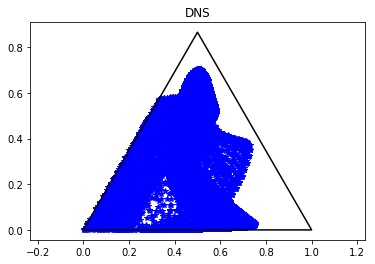

In [11]:
plt.figure()
plt.title("DNS")
plt.plot(baryMap_DNS[0,:,:],baryMap_DNS[1,:,:],'b*')
plt.plot([0,1,0.5,0],[0,0,np.sin(60*(np.pi/180)),0],'k-')
plt.axis('equal')
plt.show()

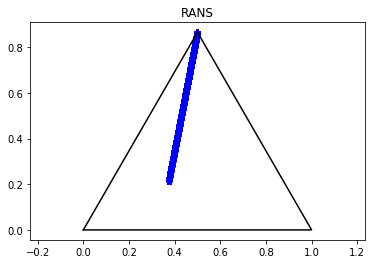

In [12]:
plt.figure()
plt.title("RANS")
plt.plot(baryMap_RANS[0,:,:],baryMap_RANS[1,:,:],'b*')
plt.plot([0,1,0.5,0],[0,0,np.sin(60*(np.pi/180)),0],'k-')
plt.axis('equal')
plt.show()

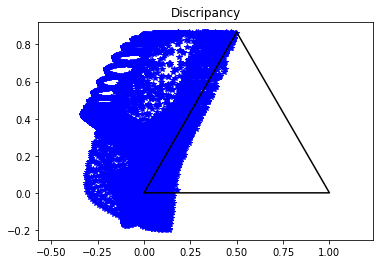

In [13]:
plt.figure()
plt.title("Discripancy")
plt.plot(baryMap_discr[0,:,:],baryMap_discr[1,:,:],'b*')
plt.plot([0,1,0.5,0],[0,0,np.sin(60*(np.pi/180)),0],'k-')
plt.axis('equal')
plt.show()

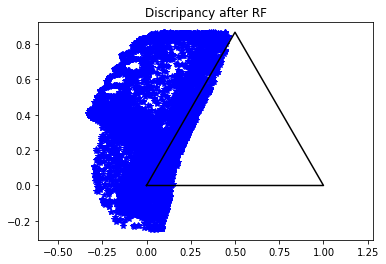

In [16]:
plt.figure()
plt.title("Discripancy after RF")
plt.plot(test_discr[0,:,:],test_discr[1,:,:],'b*')
plt.plot([0,1,0.5,0],[0,0,np.sin(60*(np.pi/180)),0],'k-')
plt.axis('equal')
plt.show()

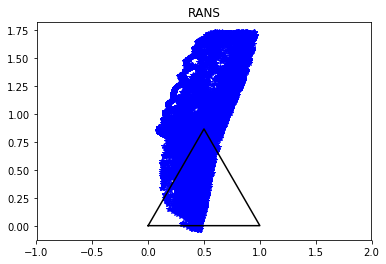

In [14]:
plt.figure()
plt.title("RANS")
plt.plot(np.add(test_discr[0,:,:], baryMap_RANS[0,:,:]) ,np.add(test_discr[1,:,:],baryMap_RANS[1,:,:]),'b*')
plt.plot([0,1,0.5,0],[0,0,np.sin(60*(np.pi/180)),0],'k-')
plt.axis('equal')
plt.show()